In [17]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus


In [19]:
username = 'root'
password = quote_plus('Nati@Nafi3')
host= 'localhost'
port='3306'
database = 'world_layoffs'
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')


In [21]:
query = "SELECT * FROM layoffs_staging2;"
df = pd.read_sql(query, engine)
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised_millions
0,Included Health,SF Bay Area,Healthcare,NaN,0.06,2022-07-25,Series E,United States,272.0
1,&Open,Dublin,Marketing,9.0,0.09,2022-11-17,Series A,Ireland,35.0
2,#Paid,Toronto,Marketing,19.0,0.17,2023-01-27,Series B,Canada,21.0
3,100 Thieves,Los Angeles,Consumer,12.0,None,2022-07-13,Series C,United States,120.0
4,10X Genomics,SF Bay Area,Healthcare,100.0,0.08,2022-08-04,Post-IPO,United States,242.0


In [23]:
# inspecting the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company                7964 non-null   object 
 1   location               7964 non-null   object 
 2   industry               7960 non-null   object 
 3   total_laid_off         6456 non-null   float64
 4   percentage_laid_off    6280 non-null   object 
 5   date                   7960 non-null   object 
 6   stage                  7944 non-null   object 
 7   country                7964 non-null   object 
 8   funds_raised_millions  7304 non-null   float64
dtypes: float64(2), object(7)
memory usage: 560.1+ KB


In [ ]:
# df.info() shows 7,964 rows and 9 columns.
# Issues noticed:
# - Missing values in industry, total_laid_off, percentage_laid_off, date, stage, and funds_raised_millions.
# - 'date' is stored as object → needs conversion to datetime.
# Next step: handle nulls and fix data types.

In [25]:
df.describe()

,total_laid_off,funds_raised_millions
count,6456.000000,7304.000000
mean,237.496902,873.527930
std,770.320358,6028.686128
min,3.000000,0.000000
25%,36.000000,51.000000
50%,80.000000,162.000000
75%,180.000000,450.000000
max,12000.000000,121900.000000


In [27]:
df.isnull().sum()

company                     0
location                    0
industry                    4
total_laid_off           1508
percentage_laid_off      1684
date                        4
stage                      20
country                     0
funds_raised_millions     660
dtype: int64

In [29]:
# converting date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [31]:
df.dtypes

company                          object
location                         object
industry                         object
total_laid_off                  float64
percentage_laid_off              object
date                     datetime64[ns]
stage                            object
country                          object
funds_raised_millions           float64
dtype: object

In [33]:
# Handling missing values so analysis won't crash or mislead
df = df.dropna(subset=['total_laid_off', 'percentage_laid_off'], how='all')
df['industry'] = df['industry'].fillna('Unkown')
df['stage'] = df['stage'].fillna('Unkown')

In [35]:
# re-check for nulls
df.isnull().sum()

company                     0
location                    0
industry                    0
total_laid_off           1508
percentage_laid_off      1684
date                        4
stage                       0
country                     0
funds_raised_millions     660
dtype: int64

In [37]:
# Dropping 4 rows with missing dates (~0.05% of data). 
# Since timeline analysis is important, rows without dates provide little value. 
# The impact on dataset size is negligible.
df = df.dropna(subset=['date'])

<Axes: title={'center': 'Total Layoffs by Year'}, xlabel='Year', ylabel='Number of Employees Laid Off'>

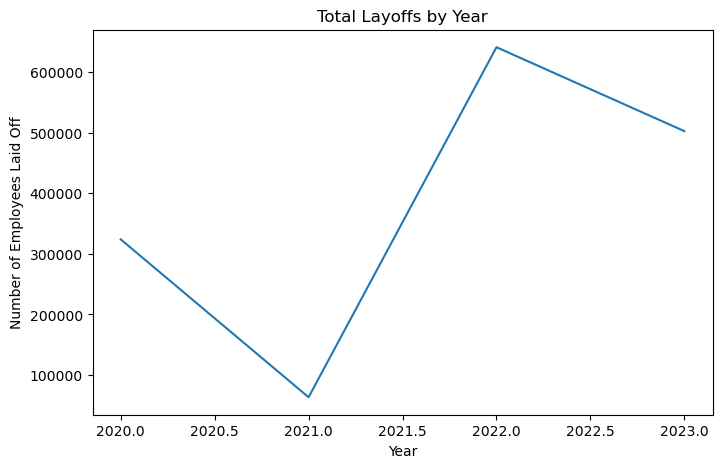

In [55]:
# Layoffs over time (trend analysis) 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

layoffs_by_year= df.groupby('year')['total_laid_off'].sum()

layoffs_by_year.plot(kind='line', title='Total Layoffs by Year', 
                     xlabel= 'Year', ylabel='Number of Employees Laid Off', figsize=(8,5))

<Axes: title={'center': 'Top 10 Industries by Layoffs'}, xlabel='Number of Employees Laid Off', ylabel='Industry'>

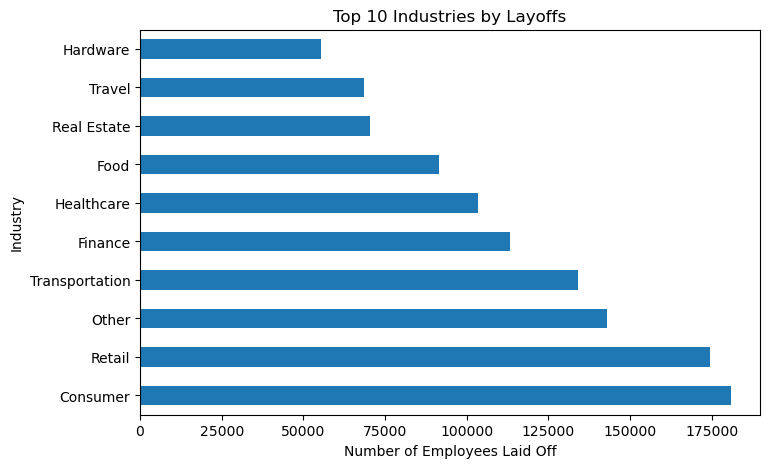

In [59]:
# Industry-wise layoffs(which industries are most affected 
layoffs_by_industry= df.groupby('industry')['total_laid_off'].sum().sort_values(ascending=False)
layoffs_by_industry.head(10).plot(kind='barh', title='Top 10 Industries by Layoffs', 
                                  xlabel= 'Number of Employees Laid Off', ylabel='Industry', figsize=(8,5))

<Axes: title={'center': 'Top 10 Companies by Layoffs'}, xlabel='Number of Employees Laid Off', ylabel='Company'>

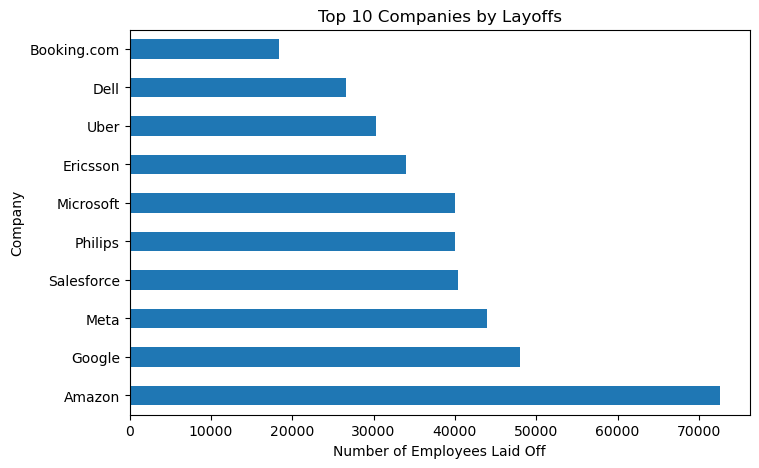

In [67]:
#Company-level insights 
top_companies= df.groupby('company')['total_laid_off'].sum().sort_values(ascending=False)
top_companies.head(10).plot(kind='barh', title='Top 10 Companies by Layoffs',
                            xlabel= 'Number of Employees Laid Off', ylabel='Company', figsize=(8,5))

<Axes: title={'center': 'Layoffs Distribution by Stage (Top 5 + Other)'}, ylabel='total_laid_off'>

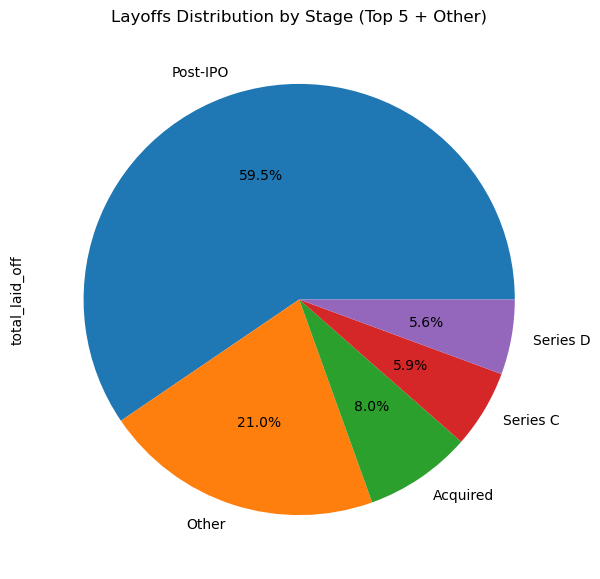

In [75]:
#compare by funding stage 
# Copy layoffs by stage data
stages_clean = layoffs_by_stage.copy()

# If "Unknown" exists, move it into "Other"
if 'Unknown' in stages_clean.index:
    other_value = stages_clean['Unknown']
    stages_clean = stages_clean.drop('Unknown')
    stages_clean['Other'] = other_value
    
# Plot Top 5 + Other
top_stages = stages_clean.sort_values(ascending=False).head(5)
others = stages_clean.sort_values(ascending=False).iloc[5:].sum()
top_stages['Other'] = others

top_stages.plot(kind='pie',
                autopct='%1.1f%%',
                figsize=(7,7),
                title='Layoffs Distribution by Stage (Top 5 + Other)')

<Axes: title={'center': 'Top 10 Countries by Layoffs'}, xlabel='Country', ylabel='Number of Employees Laid Off'>

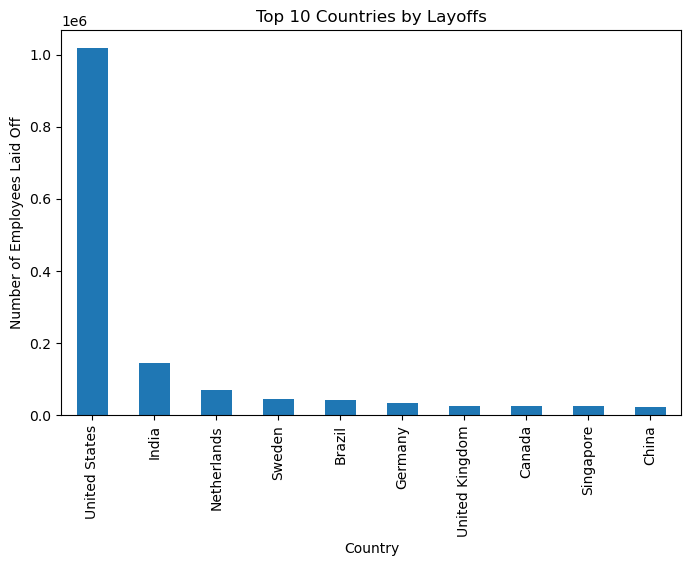

In [83]:
# Top 10 countries with the most layoffs
top_countries = layoffs_by_country.sort_values(ascending=False).head(10)

top_countries.plot(kind='bar',
                   title='Top 10 Countries by Layoffs',
                   xlabel='Country',
                   ylabel='Number of Employees Laid Off',
                   figsize=(8,5))
